# Step 1 - Prepare network data
## Project: Growing Urban Bicycle Networks

This notebook downloads bicycle and street network data sets and prepares them for analysis.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-09  
Last modified: 2024-09-06

## Preliminaries

### Parameters

In [13]:
debug = True # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [14]:
%run -i path.py
%run -i setup.py

%load_ext watermark
%watermark -n -v -m -g -iv

Loaded PATH.



=== Cities ===
{   'newcastle': {   'countryid': 'gbr',
                     'name': 'Newcastle upon Tyne',
                     'nominatimstring': 'Newcastle upon Tyne'}}


Setup finished.

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.27.0

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 19e8d1dcd8a92936e90ccacb37142aa1f2c65fdd

haversine : 2.8.1
json      : 2.0.9
fiona     : 1.10.1
shapely   : 2.0.6
IPython   : 8.27.0
osgeo     : 3.9.2
watermark : 2.5.0
sys       : 3.12.6 | packaged by conda-forge | (main, Sep 22 2024, 14:01:26) [MSC v.1941 64 bit (AMD64)]
pandas    : 2.2.3
tqdm      : 4.66.5
pyproj    : 3.6.1
matplotlib: 3.8.4
osmnx     : 1.9.4
numpy     : 1.26.4
geopandas : 0.14.4

### Functions

In [15]:
%run -i functions.py

Loaded functions.



## Download and wrangle data

### Networks

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

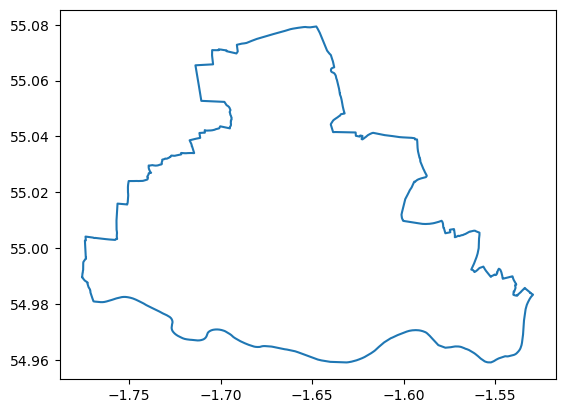

Networks:   0%|          | 0/10 [00:00<?, ?it/s]

newcastle: Successfully wrote graph car30
newcastle: Successfully wrote graph carall
newcastle: No OSM data for graph bike_cyclestreet. Created empty graph.
newcastle: No OSM data for graph bike_bicycleroad. Created empty graph.
newcastle: Successfully wrote graph biketrack
newcastle: Successfully wrote graph bikeable
newcastle: Successfully wrote graph biketrackcarall
newcastle: Successfully wrote graph biketrack_simplified
newcastle: Successfully wrote graph carall_simplified
newcastle: Successfully wrote graph bikeable_simplified
newcastle: Successfully wrote graph biketrackcarall_simplified


In [16]:
for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
        if debug: # Draw location polygons and their holes
            try:
                color = cm.rainbow(np.linspace(0,1,len(location)))
                for poly,c in zip(location, color):
                    plt.plot(*poly.exterior.xy, c = c)
                    for intr in poly.interiors:
                        plt.plot(*intr.xy, c = "red")
            except:
                plt.plot(*location.exterior.xy)
            plt.show()
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry'])) # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])

    Gs = {}
    for parameterid, parameterinfo in tqdm(osmnxparameters.items(), desc = "Networks", leave = False):
        for i in range(0,10): # retry
            try:
                Gs[parameterid] = ox.graph_from_polygon(location, 
                                       network_type = parameterinfo['network_type'],
                                       custom_filter = (parameterinfo['custom_filter']),
                                       retain_all = parameterinfo['retain_all'],
                                       simplify = False)
            except ValueError:
                Gs[parameterid] = nx.empty_graph(create_using = nx.MultiDiGraph)
                print(placeid + ": No OSM data for graph " + parameterid + ". Created empty graph.")
                break
            except ConnectionError or UnboundLocalError:
                print("ConnectionError or UnboundLocalError. Retrying.")
                continue
            except:
                print("Other error. Retrying.")
                continue
            break
        if parameterinfo['export']: ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)

    # Compose special cases biketrack, bikeable, biketrackcarall
    parameterid = 'biketrack'
    Gs[parameterid] = nx.compose_all([Gs['bike_cyclewaylefttrack'], Gs['bike_cyclewaytrack'], Gs['bike_highwaycycleway'], Gs['bike_bicycleroad'], Gs['bike_cyclewayrighttrack'], Gs['bike_designatedpath'], Gs['bike_cyclestreet']])
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)

    parameterid = 'bikeable'
    Gs[parameterid] = nx.compose_all([Gs['biketrack'], Gs['car30'], Gs['bike_livingstreet']]) 
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)

    parameterid = 'biketrackcarall'
    Gs[parameterid] = nx.compose(Gs['biketrack'], Gs['carall']) # Order is important
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)

    for parameterid in networktypes[:-2]:
        #G_temp = nx.MultiDiGraph(ox.utils_graph.get_digraph(ox.simplify_graph(Gs[parameterid]))) # This doesnt work - cant get rid of multiedges
        ox_to_csv(ox.simplify_graph(Gs[parameterid]), PATH["data"] + placeid + "/", placeid, parameterid, "_simplified")

In [17]:
# Compress all data files (will not do anything if files were compressed already)
for folder, subfolders, files in os.walk(PATH["data"]):
    for file in files:
        if file.endswith('es.csv'):
            compress_file(folder + "/", file.split(".")[0])

In [18]:
Audio(sound_file, autoplay=True)